In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import queue
import torch.nn.functional as F
import csv
import cv2

plot_queue = queue.Queue()

In [2]:
def true_function(x):
    return np.where(x < -5,
              np.sin(x) + np.cos(2*x) + 0.5*x**2 - 2,
              np.where(x < 0,
                np.sin(x) + np.cos(2*x) + 0.5*x**2 - 2*x,
                np.sin(x) + np.cos(2*x) + np.log(x + 2) + np.sqrt(x) + 10))


In [3]:
# 生成訓練數據
x_train = np.linspace(-10, 10, 1000)
y_train = true_function(x_train)

# 生成驗證數據
x_val = np.linspace(-11, 11, 200)
y_val = true_function(x_val)

# 轉換成 PyTorch 張量
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).view(-1, 1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x_train_tensor = x_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
x_val_tensor = x_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)


C:\Users\DINGNUOCHEN\AppData\Local\Temp\ipykernel_23844\3560043911.py:6: RuntimeWarning: invalid value encountered in log
  np.sin(x) + np.cos(2*x) + np.log(x + 2) + np.sqrt(x) + 10))
C:\Users\DINGNUOCHEN\AppData\Local\Temp\ipykernel_23844\3560043911.py:6: RuntimeWarning: invalid value encountered in sqrt
  np.sin(x) + np.cos(2*x) + np.log(x + 2) + np.sqrt(x) + 10))


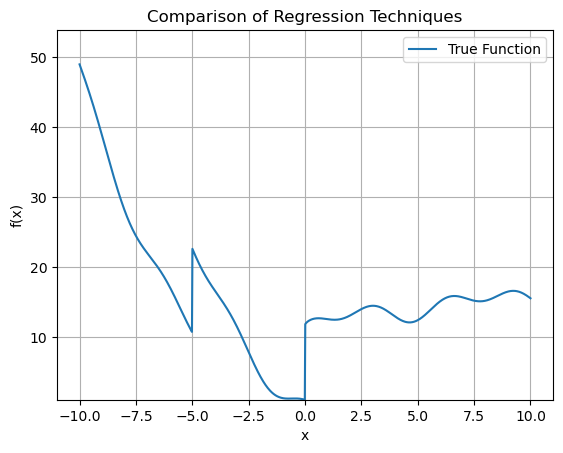

In [4]:
# 繪製結果
plt.plot(x_train, y_train, label='True Function')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Comparison of Regression Techniques')
plt.grid(True)

# 設定 y 軸的最大值為數值中的最大值*1.1
plt.ylim([min(y_train), max(y_train) * 1.1])

plt.show()

In [5]:
class PolynomialApproximator(nn.Module):
    def __init__(self):
        super(PolynomialApproximator, self).__init__()
        self.fc1 = nn.Linear(1, 128) 
        self.fc2 = nn.Linear(128, 256) 
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 1)  
        self.dropout = nn.Dropout(p=0.5)  
        self.batch_norm1 = nn.BatchNorm1d(128)  
        self.batch_norm2 = nn.BatchNorm1d(256)
        self.batch_norm3 = nn.BatchNorm1d(256)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.batch_norm1(x)  
        x = F.relu(self.fc2(x))
        x = self.batch_norm2(x)
        x = self.dropout(x)  
        x = F.relu(self.fc3(x))
        x = self.batch_norm3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.fc5(x)
        return x



# 創建模型
model = PolynomialApproximator()
model.to(device)

# 定義損失函數和優化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [6]:

# 訓練 SVR 模型
svr_model = SVR(kernel='rbf', C=1000, gamma=0.1)
svr_model.fit(x_train.reshape(-1, 1), y_train.ravel())
y_pred_svr = svr_model.predict(x_train.reshape(-1, 1))

# 訓練模型
num_epochs = 10000
csv_file = 'training_results.csv'
data_buffer = []

    

for epoch in range(num_epochs):
    model.train()  # 設置模型為訓練模式
    # 前向傳播
    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # 反向傳播與優化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 驗證
    model.eval()  # 設置模型為評估模式
    with torch.no_grad():
        val_outputs = model(x_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

        if (epoch+1) % 5 == 0:

            print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

            # 預測模型的輸出（使用 eval 模式，不需要 train）
            y_pred_tensor = model(x_train_tensor).detach().cpu().numpy()

            # 將數據存入 buffer 而不是直接寫入 CSV
            for i in range(len(x_train)):
                data_buffer.append([epoch+1, x_train[i], y_train[i], y_pred_tensor[i][0], y_pred_svr[i]])

# 訓練結束後再一次性寫入 CSV
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['epoch', 'x_train', 'y_train', 'y_pred_tensor', 'y_pred_svr'])
    writer.writerows(data_buffer)

Epoch [5/10000], Training Loss: 312.8001, Validation Loss: 435.3118
Epoch [10/10000], Training Loss: 285.5858, Validation Loss: 400.8710
Epoch [15/10000], Training Loss: 269.9369, Validation Loss: 360.1030
Epoch [20/10000], Training Loss: 260.9765, Validation Loss: 334.7549
Epoch [25/10000], Training Loss: 256.8050, Validation Loss: 334.4390
Epoch [30/10000], Training Loss: 253.4585, Validation Loss: 331.0607
Epoch [35/10000], Training Loss: 253.7773, Validation Loss: 294.4449
Epoch [40/10000], Training Loss: 247.9371, Validation Loss: 271.5818
Epoch [45/10000], Training Loss: 245.8454, Validation Loss: 262.5264
Epoch [50/10000], Training Loss: 242.2085, Validation Loss: 248.0855
Epoch [55/10000], Training Loss: 240.6565, Validation Loss: 237.9167
Epoch [60/10000], Training Loss: 236.4565, Validation Loss: 227.3607
Epoch [65/10000], Training Loss: 233.3846, Validation Loss: 223.4449
Epoch [70/10000], Training Loss: 226.9123, Validation Loss: 209.8293
Epoch [75/10000], Training Loss: 22

In [7]:
from tqdm.notebook import tqdm
import os

csv_file = 'training_results.csv'


# 創建儲存圖片的資料夾
if not os.path.exists('images'):
    os.makedirs('images')



def plot_from_csv(csv_file):
    # 讀取數據時明確指定數據格式，以確保讀取為二維陣列
    data = np.genfromtxt(csv_file, delimiter=',', skip_header=1, dtype=float)

    # 檢查數據的形狀，避免索引錯誤
    if data.ndim == 1:
        data = np.expand_dims(data, axis=0)

    # 提取不同的 epoch
    epochs = np.unique(data[:, 0])

    for epoch in tqdm(epochs):
          epoch_data = data[data[:, 0] == epoch]
          x_train = epoch_data[:, 1]
          y_train = epoch_data[:, 2]
          y_pred_tensor = epoch_data[:, 3]
          y_pred_svr = epoch_data[:, 4]

          # 生成圖表
          plt.figure(dpi=225)
          plt.ylim([min(y_train), max(y_train) * 1.1])
          plt.plot(x_train, y_train, label='True Function')
          plt.plot(x_train, y_pred_tensor, label='Neural Network Approximation', linestyle='--')
          plt.plot(x_train, y_pred_svr, label='SVR', linestyle='--')

          plt.legend()
          plt.xlabel('x')
          plt.ylabel('f(x)')
          plt.title(f'Epoch {int(epoch)}')
          plt.grid(True)

          plt.savefig(f'images/epoch_{int(epoch)}.png')
          plt.close()
          plt.clf()



# 訓練完成後，從 CSV 生成圖表
plot_from_csv(csv_file)

  0%|          | 0/2000 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

In [8]:
num_epochs = 10000

frame_rate = 60 
frame_size = (640, 480) 
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 

out = cv2.VideoWriter('polynomial_approximation.mp4', fourcc, frame_rate, frame_size)
for epoch in range(5, num_epochs+1, 5):
    filename = f'images/epoch_{epoch}.png'
    img = cv2.imread(filename)
    img_resized = cv2.resize(img, frame_size)
    out.write(img_resized)

out.release()
